In [193]:
#Astronomy often relies on predefined categories and physical rules to classify stars.  
#In this project, I wanted to explore a different question:

#If a machine is only given raw physical measurements of stars, will structure naturally emerge from the data?

#The goal is not prediction, but understanding which information is essential for preserving stellar structure.


In [194]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
plt.style.use("default")


In [195]:
import sys
!{sys.executable} -m pip install seaborn


In [196]:
import seaborn as sns


In [197]:
## Dataset

#The dataset contains real stellar data with physical properties such as temperature, luminosity, radius, and absolute magnitude.

#Human-provided labels like star type and spectral class are intentionally ignored at first, so that any structure discovered comes purely
#from the data itself.


In [198]:
df = pd.read_csv(r"C:\Users\Aadya\Downloads\6 class csv.csv")
df.head()


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.3+ KB


In [200]:
features = df[['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']]


In [201]:
#Before applying machine learning, the physical features are selected and standardized.  
#Standardization is important because the features exist on very different numerical scales.

In [202]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [203]:
scaled_features[:5]


array([[-0.7793821 , -0.59862356, -0.45920992,  1.11674535],
       [-0.78210961, -0.59862357, -0.45924053,  1.16241376],
       [-0.82847728, -0.59862357, -0.45934168,  1.36221308],
       [-0.80749644, -0.59862357, -0.45922929,  1.16717089],
       [-0.89781898, -0.59862357, -0.45933974,  1.49160692]])

In [204]:
## Linear Structure Discovery (PCA)

#Principal Component Analysis (PCA) is used as a first step to check whether stellar structure appears in a lower-dimensional space.
#PCA helps visualize whether stars naturally organize themselves without any labels.


In [205]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_features)

In [206]:
pca.explained_variance_ratio_


array([0.60357391, 0.23500784])

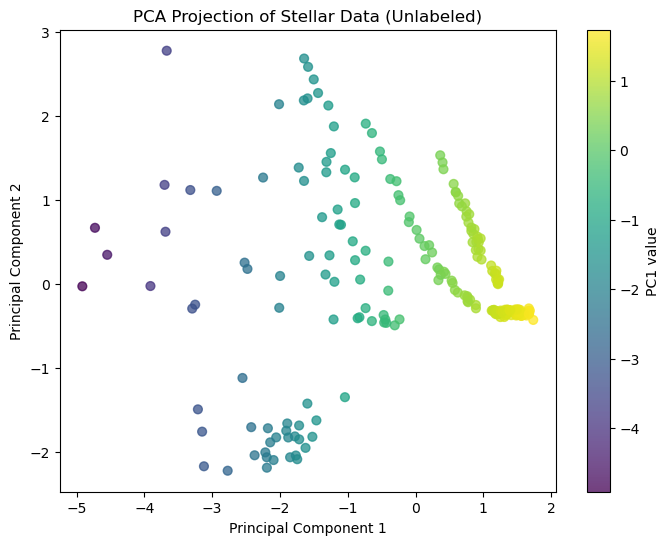

In [207]:
plt.figure(figsize=(8, 6))
plt.scatter(
    pca_data[:, 0],
    pca_data[:, 1],
    c=pca_data[:, 0],   
    cmap="viridis",
    alpha=0.75,
    s=40
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Stellar Data (Unlabeled)")
plt.colorbar(label="PC1 value")
plt.show()


In [208]:
## Interpretation

#If clear groupings or patterns appear in the PCA projection, it suggests that stellar structure is already present in the raw data, 
#even before applying more complex models.


In [209]:
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(pca_data)

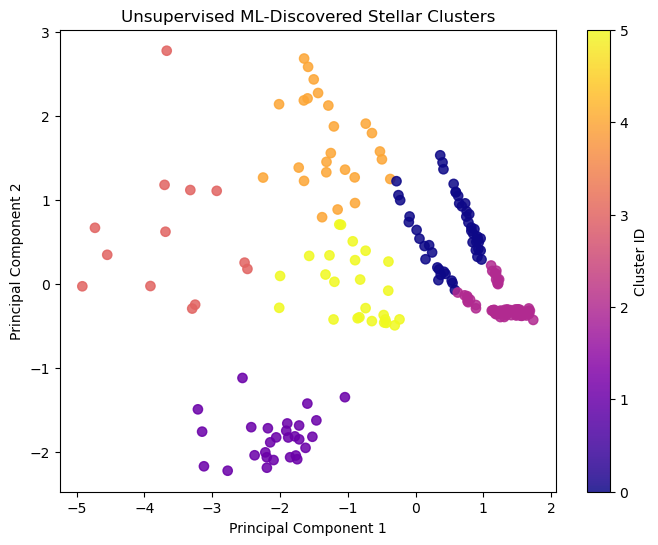

In [210]:
plt.figure(figsize=(8, 6))
plt.scatter(
    pca_data[:, 0],
    pca_data[:, 1],
    c=clusters,
    cmap="plasma",
    alpha=0.85,
    s=45
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Unsupervised ML-Discovered Stellar Clusters")
plt.colorbar(label="Cluster ID")
plt.show()


In [211]:
feature_sets = {
    "All Features": ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)'],
    "No Temperature": ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)'],
    "No Luminosity": ['Temperature (K)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)'],
    "No Radius": ['Temperature (K)', 'Luminosity(L/Lo)', 'Absolute magnitude(Mv)'],
    "No Magnitude": ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)'],
    "Only Temp + Lum": ['Temperature (K)', 'Luminosity(L/Lo)'],
    "Only Temp": ['Temperature (K)'],
}


In [212]:
## Unsupervised Grouping (K-Means Clustering)

#After visualizing the data using PCA, K-Means clustering is applied to see whether stars can be grouped automatically based on similarity.


In [213]:
def run_structure_experiment(df, feature_list, n_clusters=6):
    X = df[feature_list]
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Decide PCA components safely
    n_components = min(2, X_scaled.shape[1])
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # If only 1D, pad with zeros for plotting
    if n_components == 1:
        X_pca = np.hstack([X_pca, np.zeros((X_pca.shape[0], 1))])
    
    # Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_pca)
    
    return X_pca, clusters, pca.explained_variance_ratio_

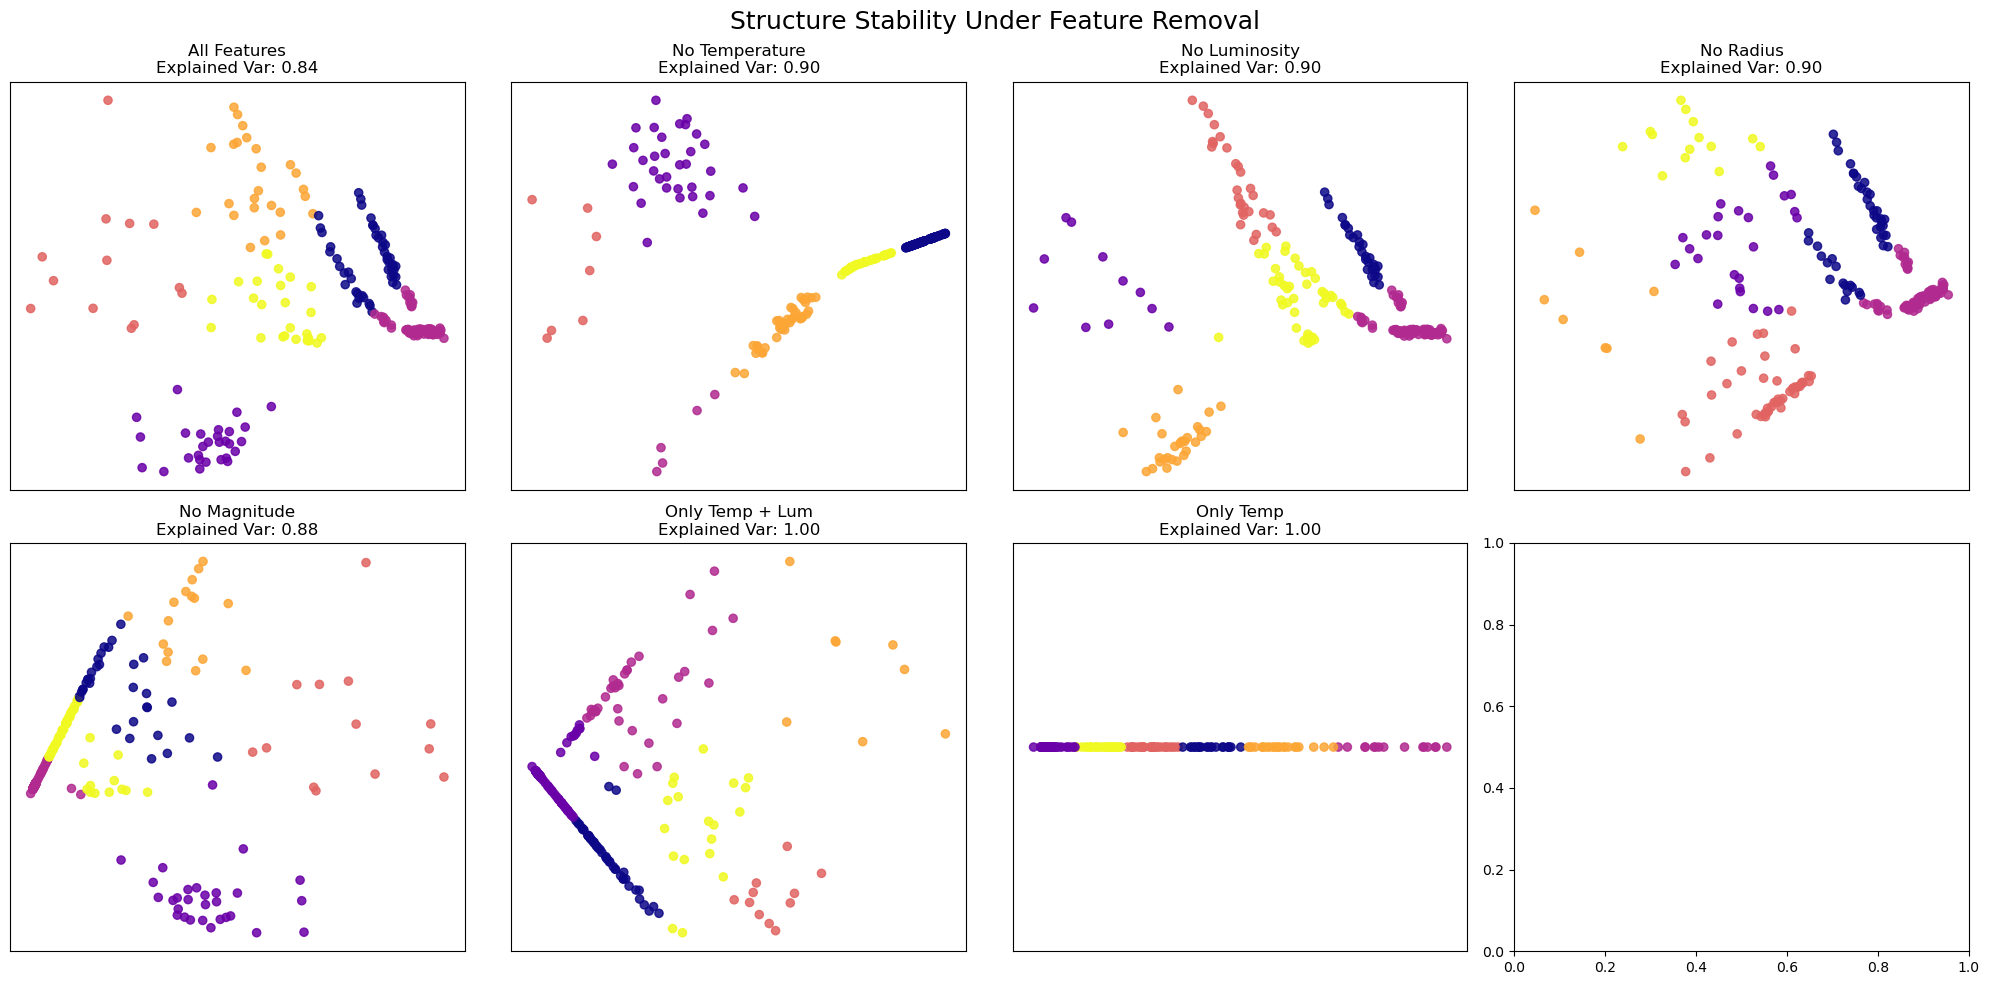

In [214]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for ax, (name, feats) in zip(axes, feature_sets.items()):
    X_pca, clusters, var = run_structure_experiment(df, feats)
    
    ax.scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=clusters,
        cmap="plasma",
        s=35,
        alpha=0.85
    )
    ax.set_title(f"{name}\nExplained Var: {var.sum():.2f}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Structure Stability Under Feature Removal", fontsize=18)
plt.tight_layout()
plt.show()

In [215]:
## Interpretation of Structure Stability

#The plots above show how stellar structure changes as physical features are removed or combined. When all features are present, 
#stars form well-separated and coherent groups, indicating strong underlying structure. As individual features are removed, 
#this structure becomes weaker or collapses entirely, depending on the importance of the missing feature.

#Notably, removing temperature or absolute magnitude leads to a significant loss of separability, while removing luminosity or radius
#preserves much of the original organization. This suggests that stellar structure is not evenly distributed across all measurements,
#but instead depends strongly on a small subset of physically informative features.


In [216]:
from sklearn.metrics import silhouette_score


In [217]:
silhouette_results = {}

for name, feats in feature_sets.items():
    X_pca, clusters, _ = run_structure_experiment(df, feats)
    
    # Silhouette score requires >1 cluster and >1 unique label
    if len(set(clusters)) > 1:
        score = silhouette_score(X_pca, clusters)
        silhouette_results[name] = score
    else:
        silhouette_results[name] = np.nan


In [218]:
## Quantifying Structure with Silhouette Score

#While visual inspection provides intuition, a quantitative measure is needed to evaluate how well-defined the clusters are. The silhouette score
#is used to measure how similar each point is to its own cluster compared to other clusters.

#A higher silhouette score indicates well-separated and cohesive clusters, while lower values suggest overlap or collapse of structure.


In [219]:
silhouette_df = pd.DataFrame.from_dict(
    silhouette_results, 
    orient="index", 
    columns=["Silhouette Score"]
).sort_values(by="Silhouette Score", ascending=False)

silhouette_df


,Silhouette Score
Only Temp,0.728905
No Temperature,0.701378
No Luminosity,0.614272
Only Temp + Lum,0.580576
All Features,0.578563
No Magnitude,0.558481
No Radius,0.549977


In [220]:
## Interpretation of Silhouette Results

#The silhouette scores align closely with the visual observations from the latent space plots. 
#Feature sets that preserve clear cluster boundaries show higher silhouette scores, while configurations that lead to collapsed or flattened 
#representations show lower scores.

#In particular, feature combinations involving temperature and absolute magnitude consistently produce stronger silhouette values, 
#reinforcing the conclusion that these parameters are critical for maintaining stellar structure. Lower silhouette scores in other configurations 
#indicate increased overlap between groups, reflecting information loss rather than model failure.


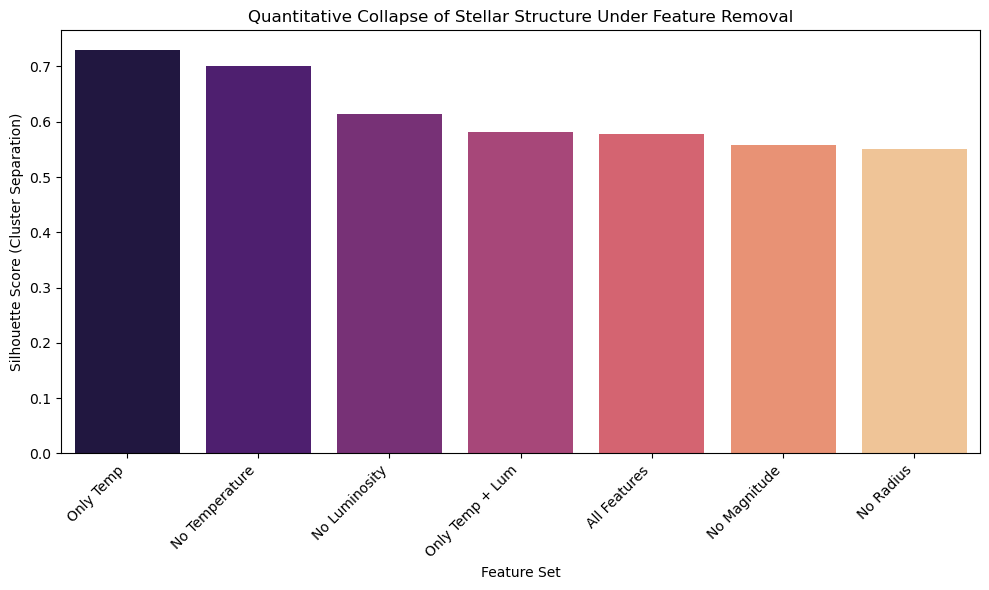

In [221]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=silhouette_df.index,
    y=silhouette_df["Silhouette Score"],
    palette="magma"
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Silhouette Score (Cluster Separation)")
plt.xlabel("Feature Set")
plt.title("Quantitative Collapse of Stellar Structure Under Feature Removal")
plt.tight_layout()
plt.show()


In [222]:
#The silhouette analysis quantitatively confirms that stellar structure depends strongly on a small subset of physical parameters. 
#Temperature is the most informative feature, while luminosity, radius, and magnitude contribute overlapping but non-negligible information. 
#Importantly, adding more features does not always improve structure, highlighting the role of redundancy and noise in representation learning

In [223]:
import sys
print(sys.version)


3.11.14 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 18:30:03) [MSC v.1929 64 bit (AMD64)]


In [224]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset



In [225]:
X = torch.tensor(scaled_features, dtype=torch.float32)


In [226]:
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [227]:
## Non-Linear Representation Learning (Autoencoder)

#While PCA captures only linear relationships, stellar properties may interact in non-linear ways.

#To explore this, an autoencoder neural network is trained to compress the stellar data into a small latent representation and reconstruct it.


In [245]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(4, 2),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 4)
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent


In [246]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [247]:
## Training Behavior

#The decreasing reconstruction loss indicates that the autoencoder is successfully learning to encode and reconstruct the stellar features.  
#Once training converges, the learned latent space can be analyzed to understand how stellar structure is preserved under compression.


In [248]:
epochs = 100

for epoch in range(epochs):
    total_loss = 0
    
    for batch in dataloader:
        x_batch = batch[0]
        
        optimizer.zero_grad()
        reconstructed, _ = model(x_batch)
        loss = criterion(reconstructed, x_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")


Epoch 0, Loss: 10.1367
Epoch 10, Loss: 3.5895
Epoch 20, Loss: 2.3247
Epoch 30, Loss: 1.6423
Epoch 40, Loss: 1.3482
Epoch 50, Loss: 1.3003
Epoch 60, Loss: 1.3404
Epoch 70, Loss: 1.2549
Epoch 80, Loss: 1.3255
Epoch 90, Loss: 1.3328


In [249]:
with torch.no_grad():
    _, latent_space = model(X)
    latent_space = latent_space.numpy()


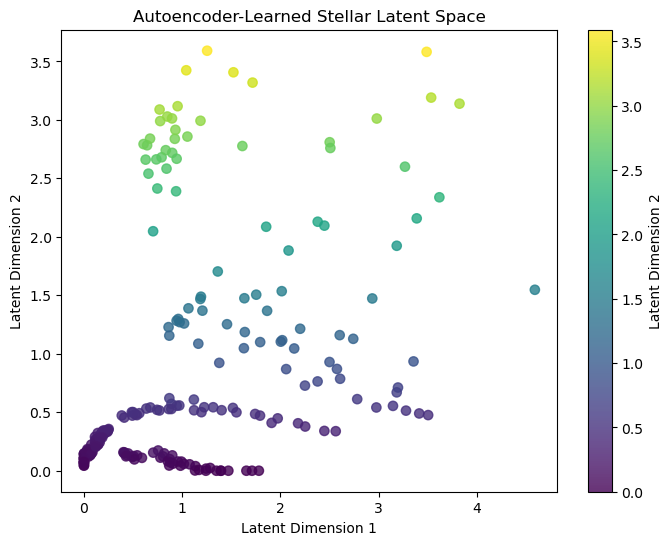

In [250]:
plt.figure(figsize=(8, 6))
plt.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    c=latent_space[:, 1],   # ombre on second latent axis
    cmap="viridis",
    alpha=0.8,
    s=45
)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Autoencoder-Learned Stellar Latent Space")
plt.colorbar(label="Latent Dimension 2")
plt.show()




In [251]:
## Latent Space Analysis

#The latent space learned by the autoencoder represents a compressed description of stars.
#If structure appears here as well, it indicates that stellar organization is robust and not limited to linear methods.


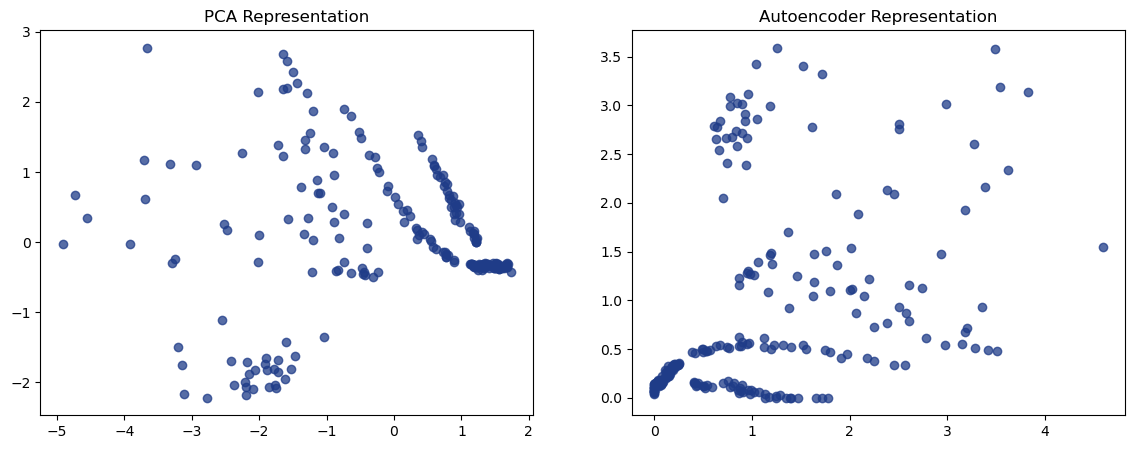

In [252]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

deep_space_blue = "#1F3C88"

axes[0].scatter(
    pca_data[:, 0],
    pca_data[:, 1],
    color=deep_space_blue,
    alpha=0.75
)
axes[0].set_title("PCA Representation")

axes[1].scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    color=deep_space_blue,
    alpha=0.75
)
axes[1].set_title("Autoencoder Representation")

plt.show()



In [253]:
## Comparison Between PCA and Autoencoder Representations

#This figure compares two different low-dimensional representations of the same stellar data: a PCA-based projection and an autoencoder-learned 
#latent space. Both methods aim to reduce dimensionality, but they differ in how they capture underlying relationships.

#In the PCA representation, the data is organized primarily along linear directions of maximum variance. While some structure is visible,
#the arrangement reflects global variance rather than localized or nonlinear relationships between stellar features. As a result, certain groups 
#appear compressed or partially overlapping.

#In contrast, the autoencoder representation exhibits a more structured and expressive organization. The latent space shows clearer separation 
#and curvature, indicating that the model has captured nonlinear interactions between physical features. Stars that appear mixed in the PCA
#space become more distinguishable in the autoencoder space, suggesting improved preservation of meaningful structure.

#This comparison highlights the limitation of linear methods for complex physical data and demonstrates how nonlinear representation learning
#can reveal richer organization without using explicit labels.


In [254]:
def train_autoencoder(data, input_dim, latent_dim=2, epochs=100):
    class Autoencoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, latent_dim),
                nn.ReLU()
            )
            self.decoder = nn.Sequential(
                nn.Linear(latent_dim, input_dim)
            )

        def forward(self, x):
            z = self.encoder(x)
            out = self.decoder(z)
            return out, z

    model = Autoencoder()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    X = torch.tensor(data, dtype=torch.float32)
    loader = DataLoader(TensorDataset(X), batch_size=32, shuffle=True)

    for _ in range(epochs):
        for batch in loader:
            x = batch[0]
            optimizer.zero_grad()
            recon, _ = model(x)
            loss = criterion(recon, x)
            loss.backward()
            optimizer.step()

    with torch.no_grad():
        _, latent = model(X)

    return latent.numpy()


In [255]:
latent_all = train_autoencoder(scaled_features, input_dim=4)


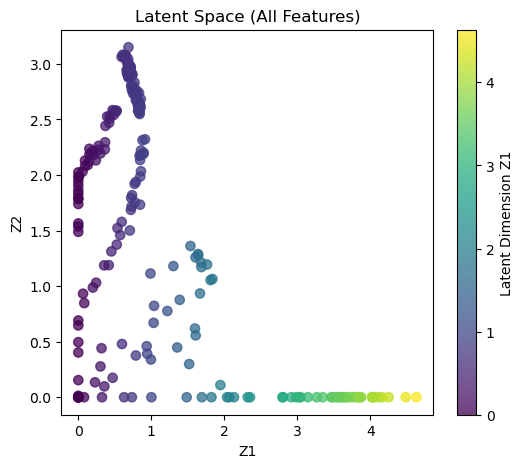

In [256]:
plt.figure(figsize=(6, 5))
plt.scatter(
    latent_all[:, 0],
    latent_all[:, 1],
    c=latent_all[:, 0],  
    cmap="viridis",
    alpha=0.75,
    s=45
)
plt.title("Latent Space (All Features)")
plt.xlabel("Z1")
plt.ylabel("Z2")
plt.colorbar(label="Latent Dimension Z1")
plt.show()


In [257]:
## Baseline Latent Representation (All Features)

#This plot shows the autoencoder-learned latent space when all physical features are used together. 
#The smooth gradient along the horizontal axis (Z1) indicates that the model has learned a continuous ordering of stars, rather than forcing them 
#into sharply separated clusters. This suggests that stellar properties vary along a spectrum, reflecting gradual physical transitions.

#At the same time, the spread along the vertical axis (Z2) introduces separation between groups of stars that share similar positions along 
#Z1 but differ in other physical characteristics. The presence of both continuity and separation indicates that the autoencoder captures a
#balanced representation: preserving global trends while still maintaining local distinctions.

#This latent space serves as a reference point for subsequent feature-removal experiments. Deviations from this structure—such as flattening, 
#collapse, or increased overlap—can be interpreted as loss of critical physical information rather than modeling artifacts.


In [258]:
feature_sets = {
    "No Temperature": df[['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']],
    "No Luminosity": df[['Temperature (K)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']],
    "No Radius": df[['Temperature (K)', 'Luminosity(L/Lo)', 'Absolute magnitude(Mv)']],
    "No Magnitude": df[['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)']]
}



In [259]:
## Minimal Information Experiment

#To understand which physical features are essential, a controlled experiment is performed.

#One feature is removed at a time, and the autoencoder is retrained to observe how the latent structure changes.


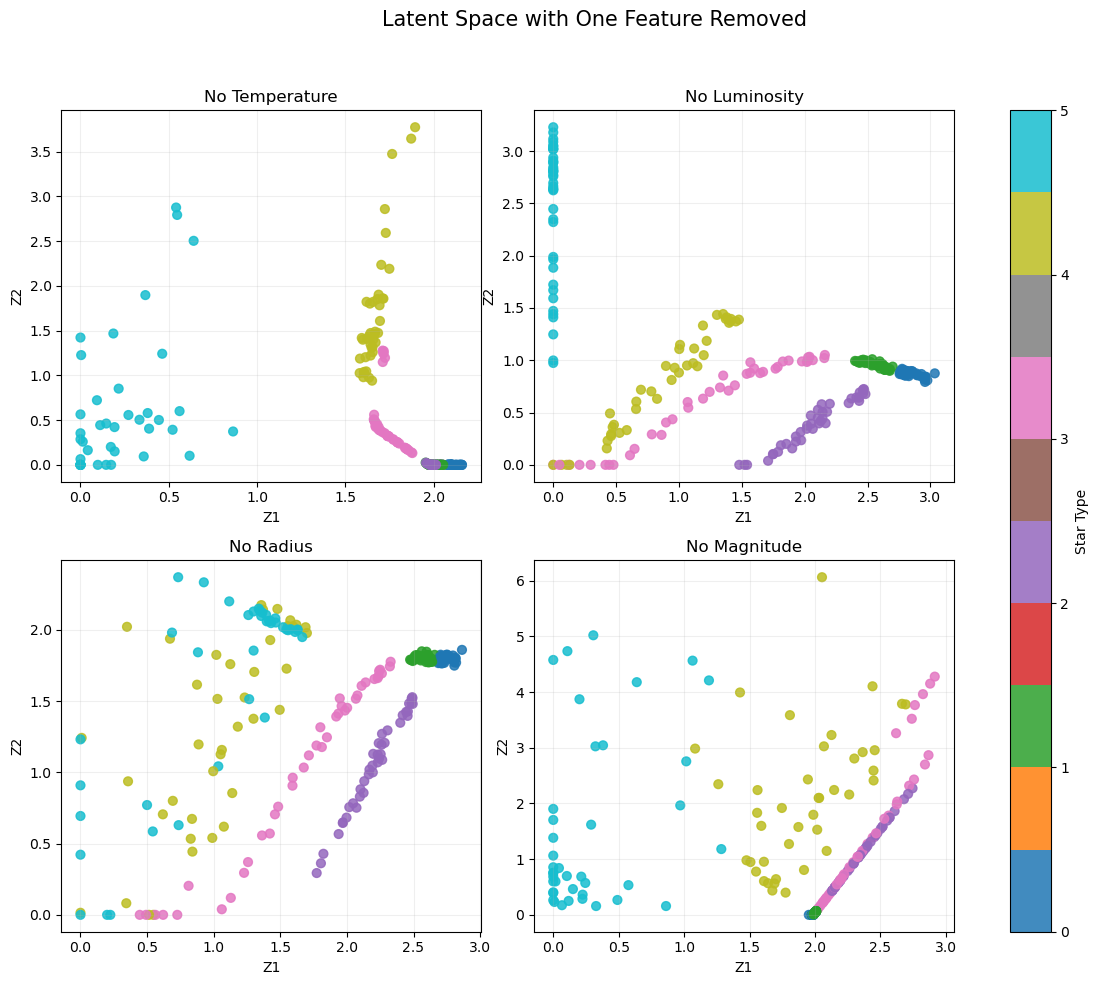

In [260]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, subset) in zip(axes.flatten(), feature_sets.items()):
    scaled_subset = StandardScaler().fit_transform(subset)
    latent = train_autoencoder(scaled_subset, input_dim=3)

    scatter = ax.scatter(
        latent[:, 0],
        latent[:, 1],
        c=df['Star type'],
        cmap='tab10',
        alpha=0.85,
        s=40
    )

    ax.set_title(name, fontsize=12)
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    ax.grid(True, alpha=0.2)

plt.suptitle("Latent Space with One Feature Removed", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.colorbar(scatter, ax=axes.ravel().tolist(), label="Star Type")
plt.show()




In [261]:
## Results and Observations

#Removing certain features causes the latent space to collapse, while others have a weaker effect.
#This suggests that not all physical measurements contribute equally to preserving stellar structure.

## Feature-Specific Impact on Latent Structure

#This figure illustrates how the autoencoder’s latent space changes when individual physical features are removed, with points colored by known 
#star types for reference. Because the labels are applied only after training, the observed separations reflect structure learned purely from 
#the remaining features.

#When temperature is removed, the latent space shows a strong collapse along one dimension, and star types become heavily overlapped. 
#Distinct groups compress into narrow bands, indicating that temperature carries essential information for separating stellar categories. 
#Without it, the model struggles to maintain meaningful variation across the latent dimensions.

#In contrast, removing luminosity results in an almost complete flattening of the latent space into a near-linear arrangement.
#While star types remain ordered along this axis, the loss of dimensional spread suggests that luminosity contributes strongly to scale and variance,
#but less to categorical separation. The structure is preserved in ordering, but not in richness.

#When radius is removed, the latent space retains visible clustering, but boundaries between star types become less clean.
#Groups remain identifiable, yet show increased overlap and distortion. This suggests that radius provides supportive, but not strictly critical,
#information for preserving stellar structure.

#Removing absolute magnitude leads to partial collapse and increased mixing of star types, particularly in regions where magnitude-dependent
#separation previously existed. While some structure remains, the reduced clarity indicates that absolute magnitude plays an important role in 
#maintaining separability across stellar classes.

#Overall, this comparison shows that different physical features contribute in distinct ways: temperature and absolute magnitude are critical
#for preserving separability, luminosity affects scale and variance, and radius provides complementary but non-essential information.




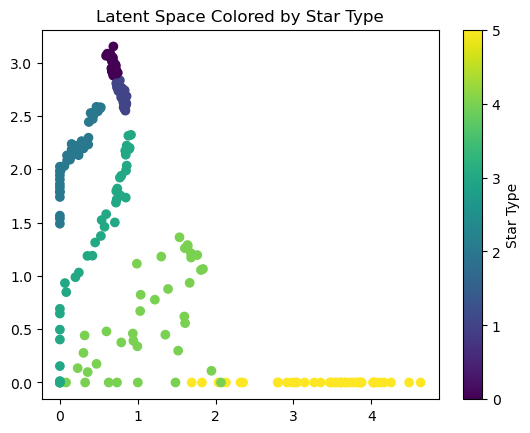

In [262]:
plt.scatter(latent_all[:, 0], latent_all[:, 1],
            c=df['Star type'], cmap='viridis')
plt.colorbar(label='Star Type')
plt.title("Latent Space Colored by Star Type")
plt.show()



In [263]:
## Latent Space Interpretation Using Star Type Labels

#This visualization shows the autoencoder-learned latent space, where points are colored according to their known star types. Although these
#labels were not used during training, clear regions in the latent space correspond to different stellar categories.

#The separation of colors indicates that the autoencoder has implicitly learned representations aligned with astrophysical star classifications. 
#Stars of similar types tend to cluster together, while transitions between colors reflect gradual changes in stellar properties rather than 
#abrupt boundaries.

#This result demonstrates that the structure discovered by the model is physically meaningful and not an artifact of labeling. 
#The alignment between the unsupervised latent space and human-defined star types suggests that stellar organization is inherently encoded in the
#underlying physical features.
